## 1.数据集下载

In [1]:
# 文件处理相关
import os

# 华为云文件传输相关
import moxing

# 将数据包从OBS下载到ModelArts
print('输入数据路径（例：obs://桶名/目录/annotations.tar.gz）')
src = input('数据路径：')
moxing.file.copy_parallel(src_url=src, dst_url='annotations.tar.gz') # 下载数据

# 解压缩数据包
os.system('tar -zxvf annotations.tar.gz')

INFO:root:Using MoXing-v1.17.3.4-4b65c6b1
INFO:root:Using OBS-Python-SDK-3.20.9.1


输入数据路径（例：obs://桶名/目录/annotations.tar.gz）
数据路径：obs://fxy4/Unet/annotations.tar.gz


0

In [2]:
# 将数据包从OBS下载到ModelArts
print('输入数据路径（例：obs://桶名/目录/images.tar.gz）')
src = input('数据路径：')
moxing.file.copy_parallel(src_url=src, dst_url='images.tar.gz') # 下载数据

# 解压缩数据包
os.system('tar -zxvf images.tar.gz')

输入数据路径（例：obs://桶名/目录/images.tar.gz）
数据路径：obs://fxy4/Unet/images.tar.gz


0

## 2.数据集加载

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

/home/ma-user/anaconda3/envs/TensorFlow-2.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 2.1设置GPU

In [2]:
# 显存自适应分配
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
gpu_ok = tf.test.is_gpu_available()
print("tf version:", tf.__version__)
print("use GPU", gpu_ok) # 判断是否使用gpu进行训练

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
tf version: 2.1.0
use GPU True


### 2.2查看数据集

In [3]:
# 读取图片
img = tf.io.read_file(r"annotations/trimaps/Abyssinian_2.png")
# 读取图片
img2 = tf.io.read_file(r"images/Abyssinian_2.jpg")
# 解码
img = tf.image.decode_png(img)
img2 = tf.image.decode_jpeg(img2)
# 查看大小
img.shape

TensorShape([473, 600, 1])

In [4]:
# 移除的所有大小为1的维度具有相同类型的张量
img = tf.squeeze(img)
img.shape

TensorShape([473, 600])

#### 2.2.1查看mask图

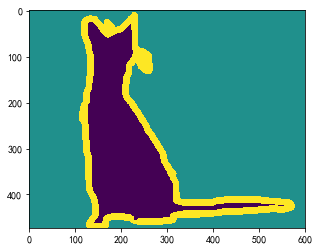

In [5]:
# 绘图
plt.imshow(img)

观察其矩阵，发现只有1,2,3三种数值，他们分别代表背景、边框、动物身体

In [6]:
img.numpy()

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=uint8)

In [7]:
np.unique(img.numpy())

array([1, 2, 3], dtype=uint8)

#### 2.2.2 查看原始图像

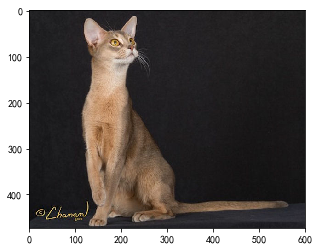

In [8]:
plt.imshow(img2)

### 2.3加载数据

In [9]:
 # 读取所有图片路径
images = glob.glob(r"images/*.jpg")
images.sort()
images[:3],len(images)

(['images/Abyssinian_1.jpg',
  'images/Abyssinian_10.jpg',
  'images/Abyssinian_100.jpg'],
 7390)

In [10]:
# 读取对应的目标图像
anno = glob.glob(r"annotations/trimaps/*.png")
anno.sort()
anno[:3],len(anno)

(['annotations/trimaps/Abyssinian_1.png',
  'annotations/trimaps/Abyssinian_10.png',
  'annotations/trimaps/Abyssinian_100.png'],
 7390)

## 3.数据预处理

### 3.1乱序

In [11]:
# 对图片进行随机
np.random.seed(2020) #设置随机数种子生成的随机数将会是同一个
index = np.random.permutation(len(images))
print(index)

[5504 2553 3749 ... 6774 4488  864]


In [16]:
images = np.array(images)[index]
anno = np.array(anno)[index]

In [17]:
images[3:],anno[3:]

(array(['images/Birman_56.jpg', 'images/Bombay_4.jpg',
        'images/Sphynx_93.jpg', ..., 'images/Maine_Coon_82.jpg',
        'images/english_setter_67.jpg',
        'images/english_cocker_spaniel_186.jpg'], dtype='<U41'),
 array(['annotations/trimaps/Birman_56.png',
        'annotations/trimaps/Bombay_4.png',
        'annotations/trimaps/Sphynx_93.png', ...,
        'annotations/trimaps/Maine_Coon_82.png',
        'annotations/trimaps/english_setter_67.png',
        'annotations/trimaps/english_cocker_spaniel_186.png'], dtype='<U54'))

### 3.2 划分训练集与测试集（4:1）

In [18]:
# 创建数据集
dataset = tf.data.Dataset.from_tensor_slices((images,anno))
# 划分数据集
test_count = int(len(images)*0.2)
train_count = len(images)-test_count
test_count,train_count

(1478, 5912)

In [19]:
# 分割数据集
data_train =dataset.skip(test_count) # 跳过test_count 的数据作为训练数据
data_test = dataset.take(test_count) #  取出test_count的数据作为测试集

### 3.3 数据集预处理

In [20]:
# 创建 jpg格式的解码函数
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img,channels=3)
    return img

In [21]:
# 创建png的解码函数
def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img,channels=1)
    return img

归一化操作

In [22]:
#  归一化
def normal_img(input_images,input_anno):
    input_images = tf.cast(input_images,tf.float32) # 改变数据类型为float32
    input_images = input_images/127.5 - 1  # 归一化到 -1 到 1 之间
    
    input_anno -= 1  # 因为目标图像取值范围是 1，2，3   我们 -1 修改为 0，1，2
    return input_images,input_anno

数据增强（随机裁剪）

In [23]:
# 数据增强，随即裁剪
def crop_img(input_image,input_anno):
    concat_img = tf.concat([input_image,input_anno],axis=-1)
    concat_img = tf.image.resize(concat_img,(280,280), # 修改大小为280*280
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)#使用最近邻插值调整images为size
    crop_img = tf.image.random_crop(concat_img,[224,224,4]) # 随机裁剪
    return crop_img[ :, :, :3],crop_img[ :, :, 3:] # 高维切片(第一，第二维度全要，第三个维度的前3是image，最后一个维度就是label)

将预处理完成的数据加载进数据集

In [24]:
# 加载训练集函数
def load_images_train(input_images_path,input_anno_path):
    input_image = read_jpg(input_images_path)
    input_anno = read_png(input_anno_path)
    
    img,anno = crop_img(input_image,input_anno)
    
    if tf.random.uniform(())>0.5: # 从均匀分布中返回随机值 如果大于0.5就执行下面的随机翻转
        img = tf.image.flip_left_right(img)
        anno = tf.image.flip_left_right(anno)
    img,anno = normal_img(img,anno) # 调用归一化函数
    
    return img,anno

In [25]:
# 加载测试集函数
def load_images_test(input_images_path,input_anno_path):
    input_image = read_jpg(input_images_path)
    input_anno = read_png(input_anno_path)
    
    input_image = tf.image.resize(input_image,(224,224))
    input_anno = tf.image.resize(input_anno,(224,224))
    
    input_image,input_anno = normal_img(input_image,input_anno)
    
    return input_image,input_anno

In [27]:
# 使用加载函数
data_train = data_train.map(load_images_train,num_parallel_calls=tf.data.experimental.AUTOTUNE)
data_test = data_test.map(load_images_test,num_parallel_calls=tf.data.experimental.AUTOTUNE)

乱序

In [29]:
BATCH_SIZE = 16
# 对数据集进行乱序
data_train = data_train.repeat().shuffle(5912).batch(BATCH_SIZE)
data_test = data_test.batch(BATCH_SIZE)

In [30]:
data_train,data_test

(<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.uint8)>,
 <BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>)

可视化训练集，以保证上述操作无误

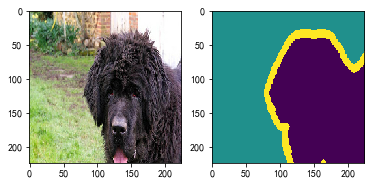

In [27]:
for img,anno in data_train.take(1):
    plt.subplot(1,2,1) # 1行2列
    plt.imshow((img[0].numpy()+1)/2)
    plt.subplot(1,2,2) # 1行2列
    plt.imshow(tf.squeeze(anno[0].numpy()))

## 4.网络构建

### 4.1预训练网络VGG16的使用

In [31]:
# 使用预训练网络
conv_base = tf.keras.applications.VGG16(weights="imagenet", # 使用该模型image权重
                                        input_shape=(224,224,3), 
                                        include_top = False)

In [32]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### 4.2网络构建

In [51]:
# 定义网络
def create_model():
    layer_names = [
    "block5_conv3", # 14x14
    "block4_conv3", # 28x28
    "block3_conv3", # 56x56
    "block5_pool"
    ] # 获取输出层的名字
    
    # 创建特征提取模型
    layers_output = [conv_base.get_layer(layer_name).output for layer_name in layer_names]
    # 从预训练网络中创建子模型
    multi_out_model = tf.keras.models.Model(inputs = conv_base.input,
                                        outputs = layers_output
                                     )
    multi_out_model.trainable = False # 禁止训练
    #构建模型
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    out_block5_conv3,out_block4_conv3,out_block3_conv3,out = multi_out_model(inputs)
    #输出512个卷积核 窗口大小3*3   图片变大2倍填充方式same保证和原有图像大小一样  激活relu
    x1 = tf.keras.layers.Conv2DTranspose(512,3,
                                         strides=2,
                                         padding="same",
                                         activation="relu")(out) # 调用out层
    x1 = tf.keras.layers.Conv2D(512,3,
                            padding="same",
                            activation="relu")(x1) # 在增加一层卷积
    
    x2 = tf.add(x1,out_block5_conv3) # 层相加
    x2 = tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding="same",activation="relu")(x2)
    x2 = tf.keras.layers.Conv2D(512,3,padding="same",activation="relu")(x2) # 在增加一层卷积
    
    x3 = tf.add(x2,out_block4_conv3) # 层相加
    x3 = tf.keras.layers.Conv2DTranspose(256,3,strides=2,padding="same",activation="relu")(x3)
    x3 = tf.keras.layers.Conv2D(256,3,padding="same",activation="relu")(x3) # 在增加一层卷积进一步提取特征
    
    x4 = tf.add(x3,out_block3_conv3)
    
    x5 = tf.keras.layers.Conv2DTranspose(128,3,strides=2,padding="same",activation="relu")(x4)
    x5 = tf.keras.layers.Conv2D(128,3,padding="same",activation="relu")(x5) # 在增加一层卷积进一步提取特征
    
    prediction = tf.keras.layers.Conv2DTranspose(3, # 因为目标图像取值是3个，所以我们输出为3
                                             3, 
                                             strides=2,
                                             padding="same",
                                             activation="softmax")(x5) # 上采样
    
    model = tf.keras.models.Model(
        inputs=inputs,
        outputs=prediction
    )
    return model

In [52]:
# 查看网络结构
model = create_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 14, 14, 512) 14714688    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 14, 14, 512)  2359808     model_1[1][3]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 512)  2359808     conv2d_transpose[0][0]           
____________________________________________________________________________________________

## 交叉验证

In [53]:
# tf.keras.metrics.MeanIoU(num_classes=34) # 根据独热编码进行计算
# 我们是顺序编码 需要更改类
class MeanIou(tf.keras.metrics.MeanIoU): # 继承这个类 
    def __call__(self,y_true,y_pred,sample_weight=None): 
        y_pred = tf.argmax(y_pred,axis=-1) 
        return super().__call__(y_true,y_pred,sample_weight=sample_weight)

In [54]:
model1 = tf.keras.models.Model(
    inputs=inputs,
    outputs=prediction
)
model2 = tf.keras.models.Model(
    inputs=inputs,
    outputs=prediction
)
model3 = tf.keras.models.Model(
    inputs=inputs,
    outputs=prediction
)
models = [model1,model2,model3]
# 编译模型
for i in range(len(models)):
    models[i].compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["acc",MeanIou(num_classes=34)]
                 )

In [ ]:
historys = []
for epoch in range(3):
    print("------------------------{}折验证-----------------------------".format(epoch+1))
    dataset = dataset.shuffle(5912)
    # 分割数据集
    train =dataset.skip(1478) # 跳过test_count 的数据作为训练数据
    val = dataset.take(test_count) #  取出test_count的数据作为测试集

    # 使用加载函数
    train = train.map(load_images_train,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val = val.map(load_images_test,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # 对数据集进行乱序
    train = train.repeat().shuffle(4434).batch(BATCH_SIZE)
    val = val.batch(BATCH_SIZE)
    
    history = models[i].fit(train,
              epochs=5,
              steps_per_epoch=train_count//BATCH_SIZE,
              validation_data=val,
              validation_steps=test_count//BATCH_SIZE,
    )
    historys.append(history)

------------------------1折验证-----------------------------
Train for 369 steps, validate for 92 steps
Epoch 1/5
369/369 [==============================] - 68s 186ms/step - loss: 0.4037 - acc: 0.8436 - mean_iou_2: 0.6633 - val_loss: 0.3224 - val_acc: 0.8765 - val_mean_iou_2: 0.7080
Epoch 2/5
369/369 [==============================] - 56s 152ms/step - loss: 0.3143 - acc: 0.8807 - mean_iou_2: 0.7235 - val_loss: 0.2731 - val_acc: 0.8931 - val_mean_iou_2: 0.7417
Epoch 3/5
369/369 [==============================] - 56s 153ms/step - loss: 0.2847 - acc: 0.8912 - mean_iou_2: 0.7420 - val_loss: 0.2503 - val_acc: 0.9016 - val_mean_iou_2: 0.7505
Epoch 4/5
369/369 [==============================] - 56s 153ms/step - loss: 0.2727 - acc: 0.8954 - mean_iou_2: 0.7499 - val_loss: 0.2523 - val_acc: 0.9001 - val_mean_iou_2: 0.7531
Epoch 5/5
369/369 [==============================] - 57s 154ms/step - loss: 0.2610 - acc: 0.8999 - mean_iou_2: 0.7576 - val_loss: 0.2564 - val_acc: 0.8987 - val_mean_iou_2: 0.7537

Text(0,0.5,'Accuracy')

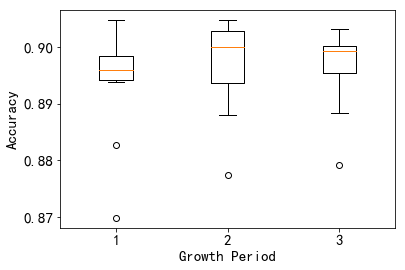

In [58]:
# 3折交叉验证
accs = []
for i in range(len(historys)):
    acc = historys.history["acc"]
    accs.append(acc)
plt.boxplot((accs[0],accs[1],accs[2]),labels=('1','2','3'))
plt.axis()
plt.xlabel('Growth Period')
plt.ylabel('Accuracy')
plt.show()

## 6.训练

In [58]:
model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["acc",MeanIou(num_classes=34)]
                 )

In [59]:
# 训练模型
history = model.fit(data_train,
                    epochs=30,
                    steps_per_epoch=train_count//BATCH_SIZE,
                    validation_data=data_test,
                    validation_steps=test_count//BATCH_SIZE,
)

Train for 369 steps, validate for 92 steps
Epoch 1/30
369/369 [==============================] - 79s 215ms/step - loss: 0.4236 - acc: 0.8357 - mean_iou_3: 0.6517 - val_loss: 0.3271 - val_acc: 0.8744 - val_mean_iou_3: 0.7082
Epoch 2/30
369/369 [==============================] - 57s 154ms/step - loss: 0.3107 - acc: 0.8814 - mean_iou_3: 0.7248 - val_loss: 0.2636 - val_acc: 0.8926 - val_mean_iou_3: 0.7350
Epoch 3/30
369/369 [==============================] - 57s 154ms/step - loss: 0.2841 - acc: 0.8911 - mean_iou_3: 0.7429 - val_loss: 0.2736 - val_acc: 0.8935 - val_mean_iou_3: 0.7433
Epoch 4/30
369/369 [==============================] - 56s 153ms/step - loss: 0.2695 - acc: 0.8968 - mean_iou_3: 0.7526 - val_loss: 0.2554 - val_acc: 0.8993 - val_mean_iou_3: 0.7522
Epoch 5/30
369/369 [==============================] - 56s 153ms/step - loss: 0.2627 - acc: 0.8991 - mean_iou_3: 0.7574 - val_loss: 0.2582 - val_acc: 0.8990 - val_mean_iou_3: 0.7516
Epoch 6/30
369/369 [==============================] 

## 7.训练结果可视化

### 7.1 loss曲线

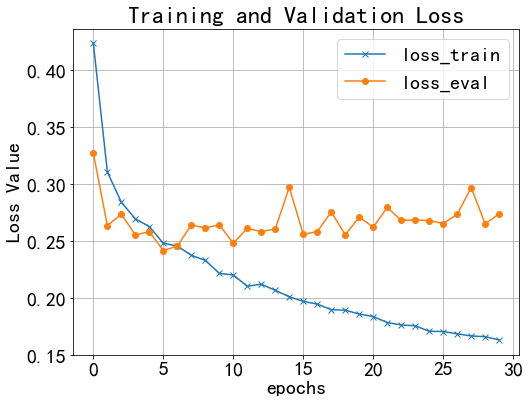

In [60]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.rcParams.update({"font.size":20})
plt.figure(figsize=(8,6))
plt.plot(loss,marker='x',label="Trainning loss")
plt.plot(val_loss,marker='o',label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("epochs")
plt.ylabel("Loss Value")
plt.grid()
plt.legend(['loss_train', 'loss_eval'], loc='upper right')
plt.show()

### 7.2准确率曲线

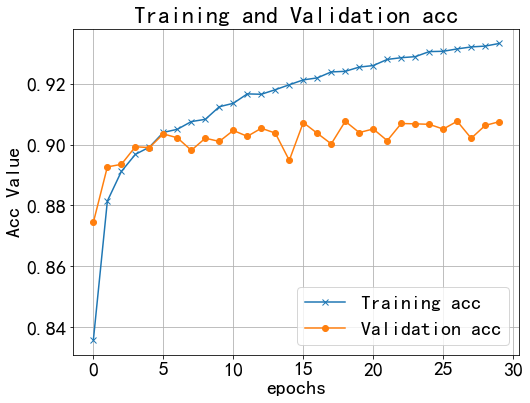

In [62]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
plt.figure(figsize=(8,6))
plt.plot(acc,marker='x',label="Training acc")
plt.plot(val_acc,marker='o',label="Validation acc")
plt.title("Training and Validation acc")
plt.xlabel("epochs")
plt.ylabel("Acc Value")
plt.grid()
plt.legend()
plt.show()

### 7.3 平均IoU曲线

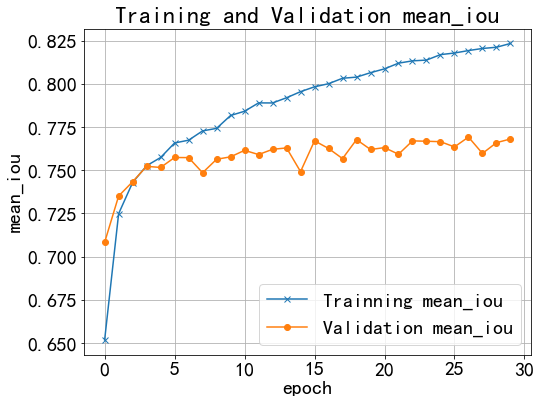

In [65]:
meanIoU = history.history["mean_iou_3"]
val_meanIoU = history.history["val_mean_iou_3"]

plt.figure(figsize=(8,6))
plt.plot(meanIoU,marker='x',label="Trainning mean_iou")
plt.plot(val_meanIoU,marker='o',label="Validation mean_iou")
plt.title("Training and Validation mean_iou")
plt.xlabel("epoch")
plt.ylabel("mean_iou")
plt.grid()
plt.legend()
plt.show()

## 8.可视化预测结果

### 8.1测试数据集中的测试集

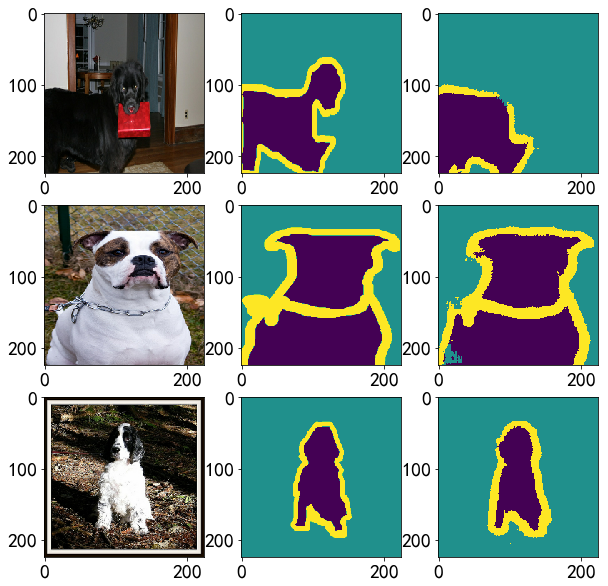

In [66]:
num = 3
for image, mask in data_test.take(1): # 从test数据取出一个batch
    pred_mask = model.predict(image) # model.predict(image) 对图片进行预测
    pred_mask = tf.argmax(pred_mask, axis=-1)  # 取出预测最大值
    pred_mask = pred_mask[..., tf.newaxis] # 维度扩展 取前面所有维度
    
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num,3,i*num+1)
        plt.imshow((image[i].numpy()+1)/2)
        plt.subplot(num,3,i*num+2)
        plt.imshow(tf.squeeze(mask[i].numpy()))
        plt.subplot(num,3,i*num+3)
        plt.imshow(tf.squeeze(pred_mask[i].numpy()))

### 8.2 额外数据集测试

In [67]:
# 将数据包从OBS下载到ModelArts
print('输入数据路径（例：obs://桶名/目录/test.zip）')
src = input('数据路径：')
moxing.file.copy_parallel(src_url=src, dst_url='test.zip') # 下载数据

# 解压缩数据包
os.system('unzip test.zip')

输入数据路径（例：obs://桶名/目录/test.zip）
数据路径：obs://fxy4/Unet/test.zip


0

In [68]:
# 读取所有图片路径
test_imgs = glob.glob(r"imgs/*.jpg")
test_imgs.sort()
test_imgs[:5],len(test_imgs)

(['imgs/black-white-kittens2.jpg',
  'imgs/black_kitten.jpg',
  'imgs/black_kitten_star.jpg',
  'imgs/cat-jumping-running-grass.jpg',
  'imgs/cat_bed.jpg'],
 16)

In [69]:
# 读取所有图片路径
test_anno = glob.glob(r"gt/*.png")
test_anno.sort()
test_anno[:5],len(test_anno)

(['gt/black-white-kittens2.png',
  'gt/black_kitten.png',
  'gt/black_kitten_star.png',
  'gt/cat-jumping-running-grass.png',
  'gt/cat_bed.png'],
 16)

In [70]:
dataset_demo = tf.data.Dataset.from_tensor_slices((test_imgs,test_anno))

In [71]:
# 加载测试集函数
def load_images_demo(input_images_path, input_anno_path):
    input_image = read_jpg(input_images_path)
    input_anno = read_png(input_anno_path)
    
    input_image = tf.image.resize(input_image,(224,224))
    input_anno = tf.image.resize(input_anno,(224,224))
    
    input_image = tf.cast(input_image,tf.float32)
    input_image = input_image/127.5 - 1
    
    return input_image,input_anno

In [72]:
data_test_demo = dataset_demo.map(load_images_demo,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
data_test_demo = data_test_demo.batch(BATCH_SIZE)

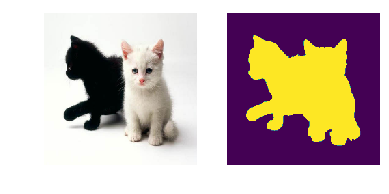

In [73]:
for image,mask in data_test_demo.take(1):
    plt.subplot(1,2,1)
    plt.imshow((image[0].numpy()+1)/2)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(mask[0]))
    plt.axis('off')

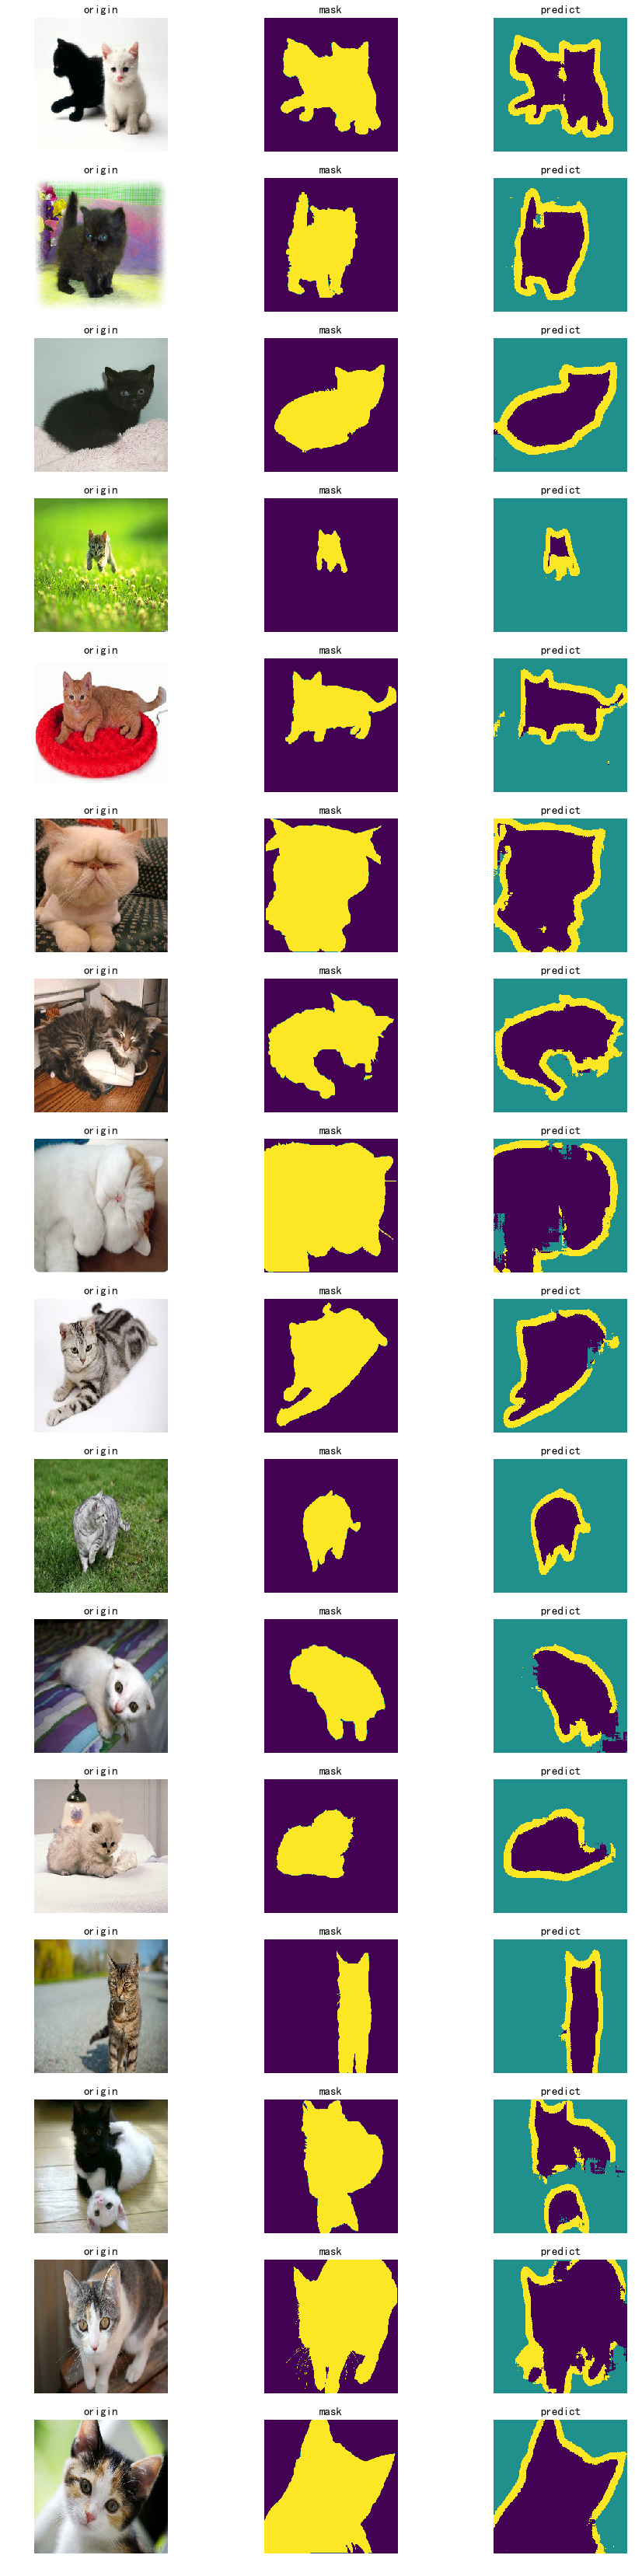

In [74]:
# for image,mask in data_test_demo:
plt.figure(figsize=(15,60))
for images,mask in data_test_demo:
    pred_mask = model.predict(images)
    pred_mask = tf.argmax(pred_mask,axis=-1)
    pred_mask = pred_mask[...,tf.newaxis]

    for i in range(len(images)):
        plt.subplot(len(images),3,i*num+1)
        plt.imshow((images[i].numpy()+1)/2)
        plt.axis('off')
        plt.title('origin',fontsize=15)
        plt.subplot(len(images),3,i*num+2)
        plt.imshow(tf.squeeze(mask[i].numpy()))
        plt.axis('off')
        plt.title('mask',fontsize=15)
        plt.subplot(len(images),3,i*num+3)
        plt.imshow(tf.squeeze(pred_mask[i].numpy()))
        plt.axis('off')
        plt.title('predict',fontsize=15)